In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Use T4 Tesla From google-colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
#Added a dense layer to better capture the data
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(512, 1024, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(1024, 2048, 4, 2, 1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, 2, 1), nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [7]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    scheduler.step()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20, Loss: 0.0207
Epoch 2/20, Loss: 0.0138
Epoch 3/20, Loss: 0.0097
Epoch 4/20, Loss: 0.0077
Epoch 5/20, Loss: 0.0069
Epoch 6/20, Loss: 0.0061
Epoch 7/20, Loss: 0.0056
Epoch 8/20, Loss: 0.0049
Epoch 9/20, Loss: 0.0045
Epoch 10/20, Loss: 0.0042
Epoch 11/20, Loss: 0.0039
Epoch 12/20, Loss: 0.0036
Epoch 13/20, Loss: 0.0034
Epoch 14/20, Loss: 0.0033
Epoch 15/20, Loss: 0.0032
Epoch 16/20, Loss: 0.0031
Epoch 17/20, Loss: 0.0030
Epoch 18/20, Loss: 0.0030
Epoch 19/20, Loss: 0.0030
Epoch 20/20, Loss: 0.0030


In [10]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, _ = batch
        images = images.to(device)
        outputs = model(images)
        break

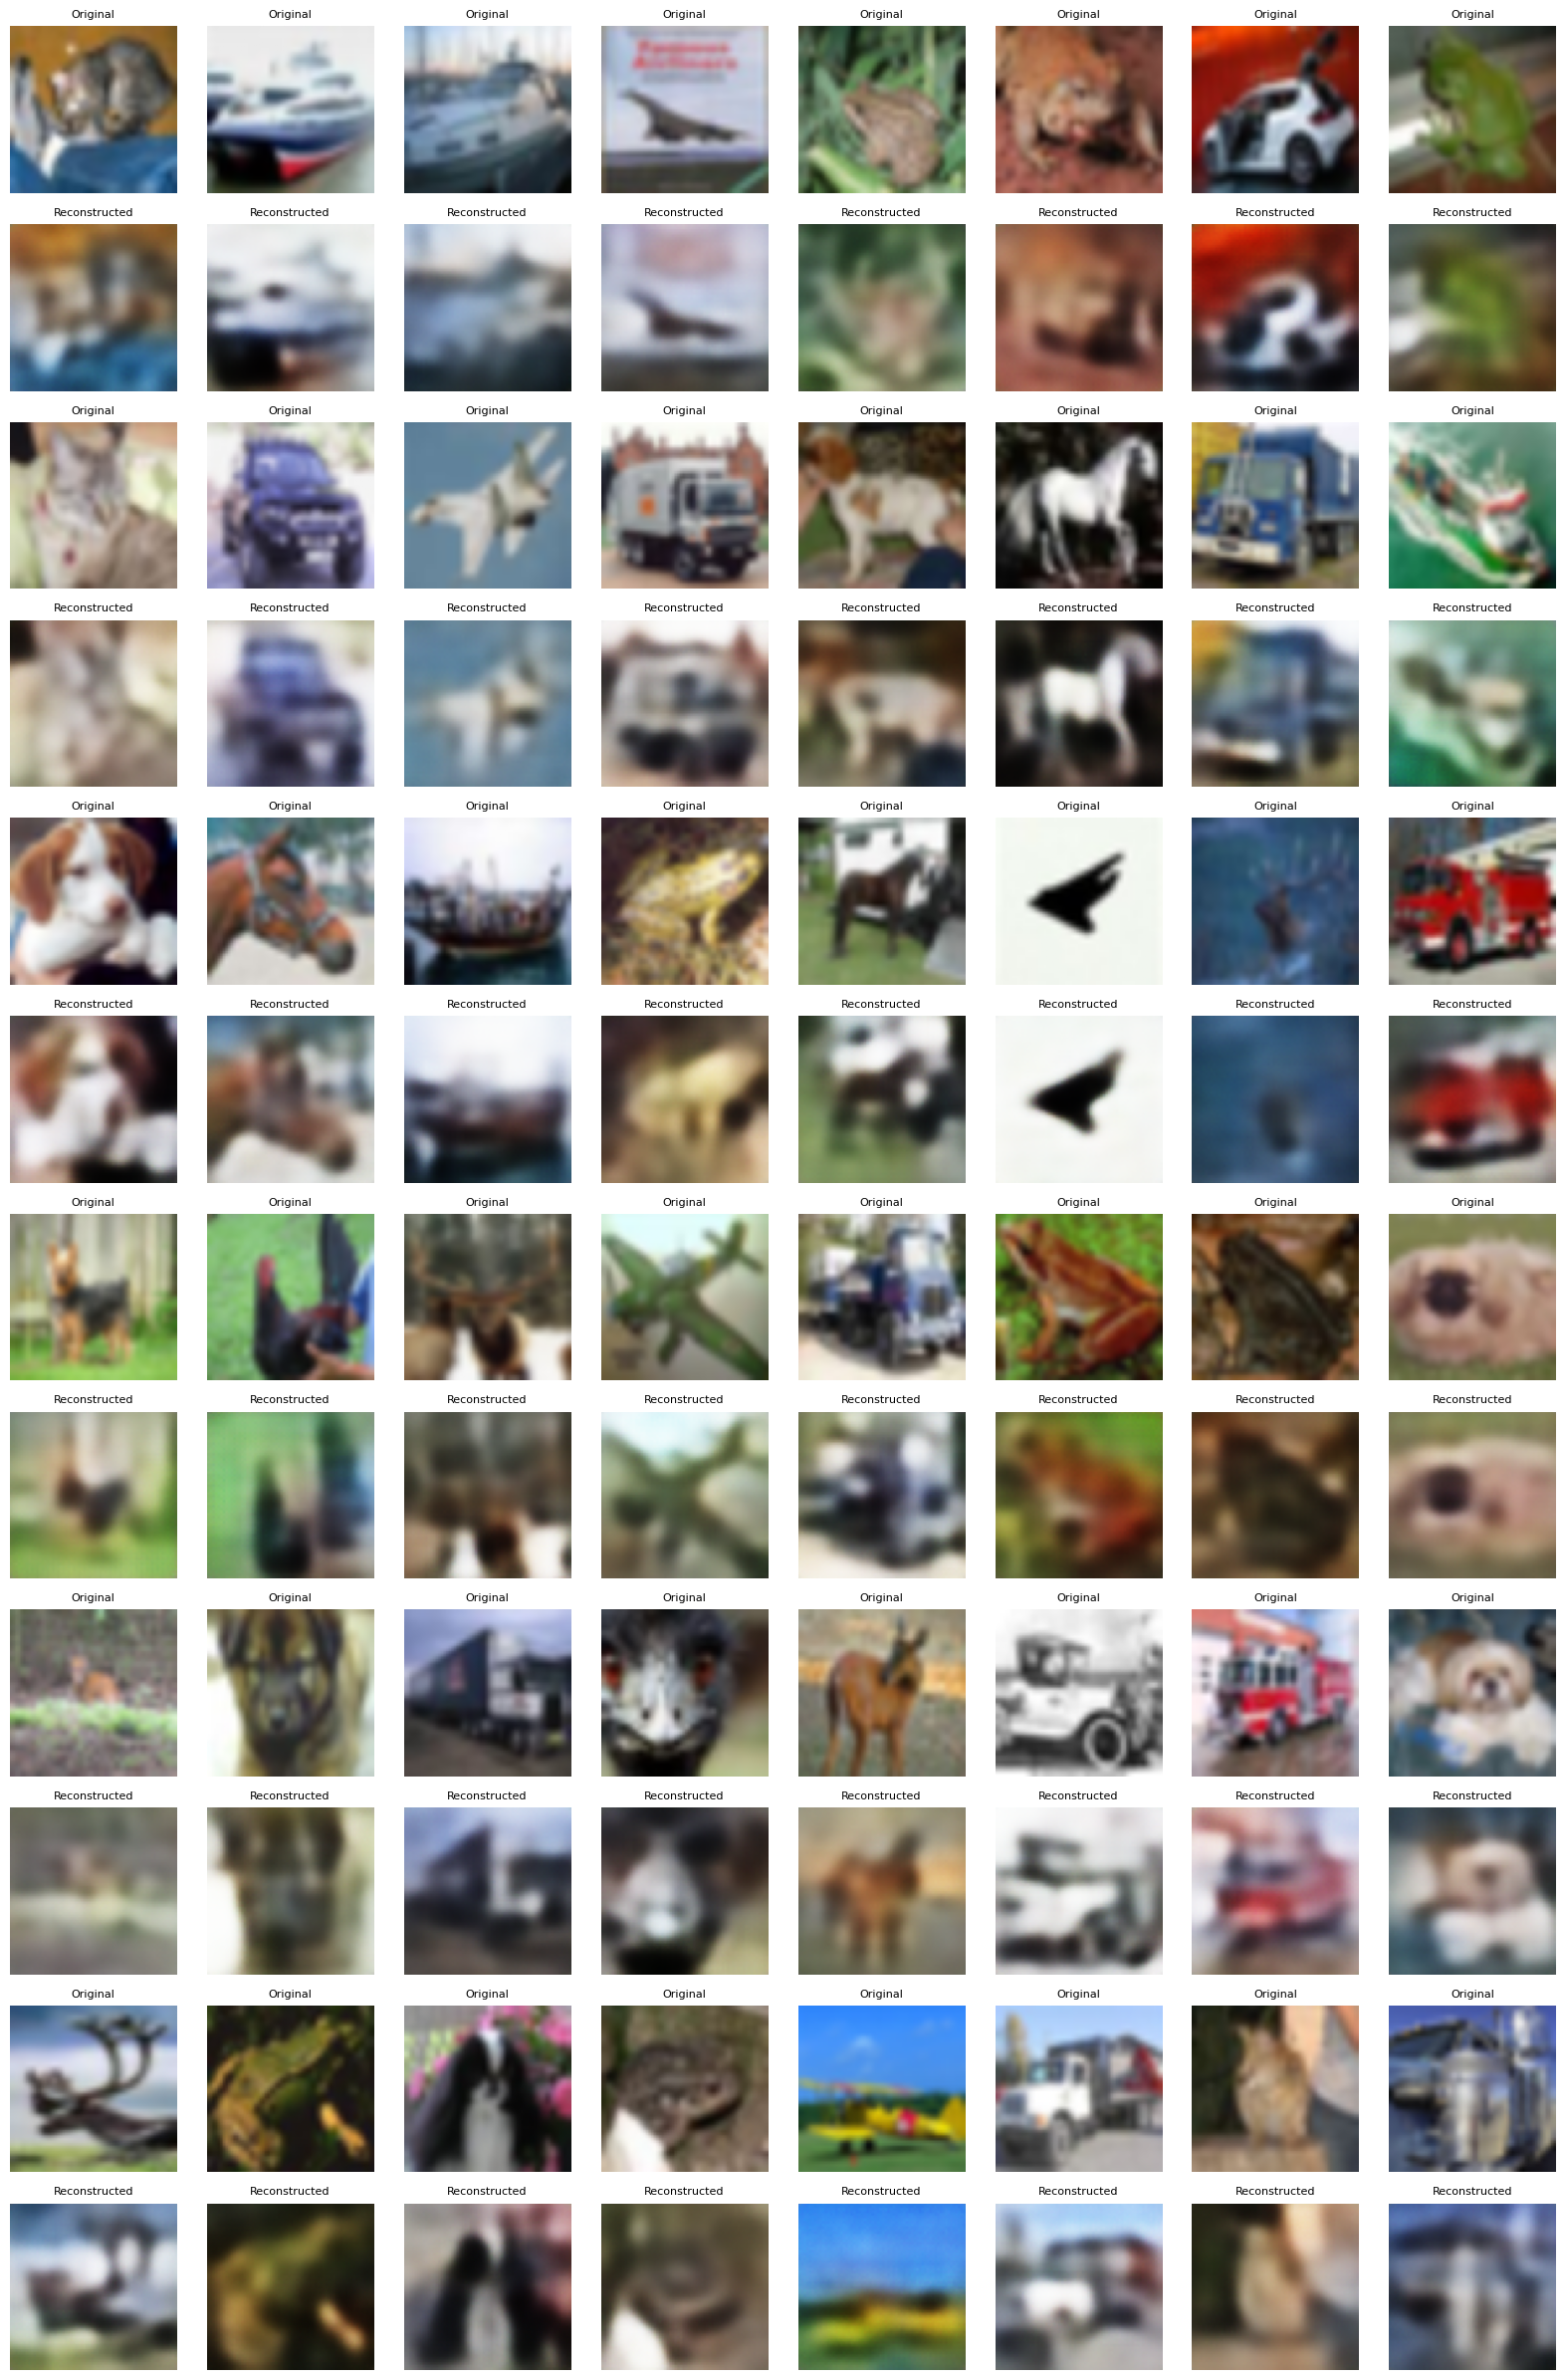

In [11]:
#Visualization
def show_many_images(orig, recon, num=24):
    assert num % 8 == 0, "Choose multiple of 8"
    rows = 2 * (num // 8)
    fig, axs = plt.subplots(rows, 8, figsize=(16, rows * 2))

    orig = orig[:num].detach().cpu().float().numpy()
    recon = recon[:num].detach().cpu().float().numpy()

    for i in range(num):
        row = (i // 8) * 2
        col = i % 8

        axs[row, col].imshow(np.transpose(orig[i], (1, 2, 0)))
        axs[row, col].set_title("Original", fontsize=8)
        axs[row, col].axis('off')

        axs[row+1, col].imshow(np.transpose(recon[i], (1, 2, 0)))
        axs[row+1, col].set_title("Reconstructed", fontsize=8)
        axs[row+1, col].axis('off')

    plt.tight_layout()
    plt.show()


show_many_images(images, outputs, num=48)
